# Colab B: PyTorch From Scratch - 3-Layer Deep Neural Network for Non-Linear Regression

## Overview
- **3-layer deep neural network** built from scratch using PyTorch tensors
- **WITHOUT using PyTorch built-in layer functionality** (no nn.Module, no nn.Linear)
- Manual weight initialization, forward pass, backpropagation
- Same 3-variable non-linear regression problem

### Target Non-Linear Equation
$$y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + x_2 \cdot x_3^2$$

### Network Architecture
- Input Layer: 3 neurons
- Hidden Layer 1: 64 neurons (ReLU)
- Hidden Layer 2: 32 neurons (ReLU)
- Hidden Layer 3: 16 neurons (ReLU)
- Output Layer: 1 neuron (Linear)

In [1]:
# ============================================================
# Section 1: Imports
# ============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

PyTorch version: 2.10.0+cu128
Device: cuda


In [2]:
# ============================================================
# Section 2: Generate Synthetic Data
# ============================================================
N_SAMPLES = 1000

# Generate 3 input variables
x1 = np.random.uniform(-2, 2, (N_SAMPLES, 1))
x2 = np.random.uniform(-2, 2, (N_SAMPLES, 1))
x3 = np.random.uniform(-2, 2, (N_SAMPLES, 1))

# Non-linear target: y = sin(x1)*x2^2 + cos(x3)*x1 + x2*x3^2
y = np.sin(x1) * x2**2 + np.cos(x3) * x1 + x2 * x3**2
X = np.hstack([x1, x2, x3])

# Normalize
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
y_mean, y_std = y.mean(), y.std()
X_norm = (X - X_mean) / X_std
y_norm = (y - y_mean) / y_std

# Train/test split
split = int(0.8 * N_SAMPLES)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_norm[:split]).to(device)
y_train = torch.FloatTensor(y_norm[:split]).to(device)
X_test = torch.FloatTensor(X_norm[split:]).to(device)
y_test = torch.FloatTensor(y_norm[split:]).to(device)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")
print(f"Target: y = sin(x1)*x2^2 + cos(x3)*x1 + x2*x3^2")

X_train: torch.Size([800, 3]), y_train: torch.Size([800, 1])
X_test:  torch.Size([200, 3]),  y_test:  torch.Size([200, 1])
Target: y = sin(x1)*x2^2 + cos(x3)*x1 + x2*x3^2


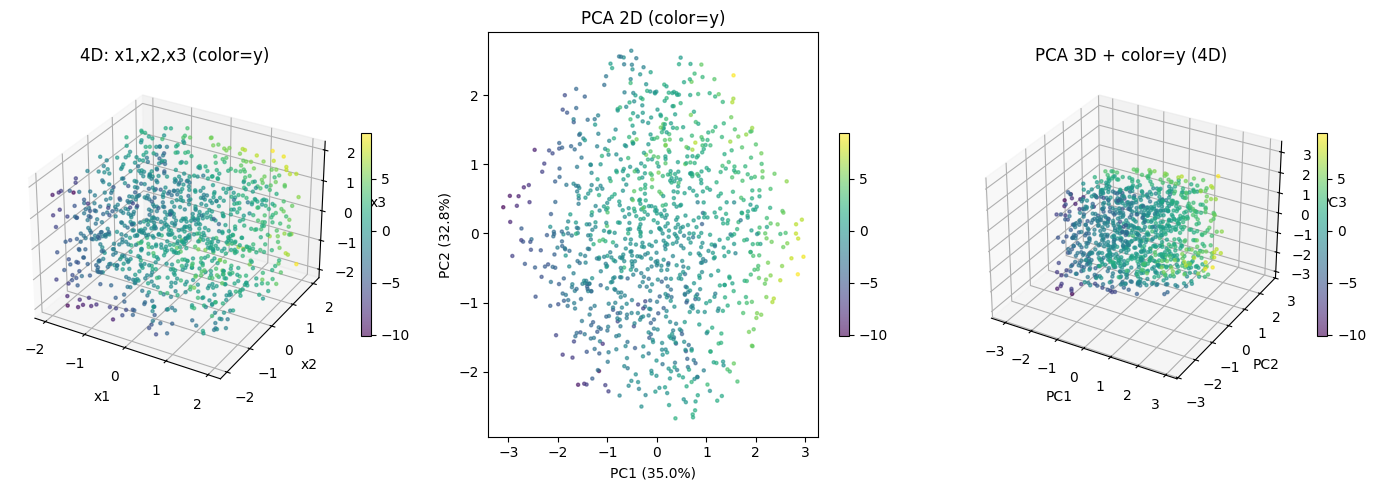

In [3]:
# ============================================================
# Section 3: 4D Data Visualization
# ============================================================
fig = plt.figure(figsize=(14, 5))

# 4D Plot: 3 spatial dims + color for y
ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax1.set_xlabel('x1'); ax1.set_ylabel('x2'); ax1.set_zlabel('x3')
ax1.set_title('4D: x1,x2,x3 (color=y)')
plt.colorbar(sc1, ax=ax1, shrink=0.5)

# PCA 2D
pca2 = PCA(n_components=2)
Xp2 = pca2.fit_transform(X)
ax2 = fig.add_subplot(132)
sc2 = ax2.scatter(Xp2[:, 0], Xp2[:, 1], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax2.set_xlabel(f'PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}%)')
ax2.set_title('PCA 2D (color=y)')
plt.colorbar(sc2, ax=ax2, shrink=0.5)

# PCA 3D
pca3 = PCA(n_components=3)
Xp3 = pca3.fit_transform(X)
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(Xp3[:, 0], Xp3[:, 1], Xp3[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax3.set_xlabel('PC1'); ax3.set_ylabel('PC2'); ax3.set_zlabel('PC3')
ax3.set_title('PCA 3D + color=y (4D)')
plt.colorbar(sc3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

In [4]:
# ============================================================
# Section 4: Initialize Weights From Scratch (No nn.Module!)
# ============================================================
# Architecture: 3 -> 64 -> 32 -> 16 -> 1

def he_init_torch(fan_in, fan_out, device):
    """He initialization using raw PyTorch tensors."""
    std = np.sqrt(2.0 / fan_in)
    W = torch.randn(fan_in, fan_out, device=device) * std
    W.requires_grad_(True)  # Enable gradient tracking
    return W

def zero_bias_torch(size, device):
    """Create zero bias with gradient tracking."""
    b = torch.zeros(1, size, device=device)
    b.requires_grad_(True)
    return b

torch.manual_seed(42)

# Layer dimensions
dims = [3, 64, 32, 16, 1]

# Raw tensor weights - NO nn.Linear, NO nn.Module!
W1 = he_init_torch(dims[0], dims[1], device)
b1 = zero_bias_torch(dims[1], device)

W2 = he_init_torch(dims[1], dims[2], device)
b2 = zero_bias_torch(dims[2], device)

W3 = he_init_torch(dims[2], dims[3], device)
b3 = zero_bias_torch(dims[3], device)

W4 = he_init_torch(dims[3], dims[4], device)
b4 = zero_bias_torch(dims[4], device)

# Collect all parameters for gradient descent
all_params = [W1, b1, W2, b2, W3, b3, W4, b4]

total = sum(p.numel() for p in all_params)
print("Network Parameters (raw tensors, NO nn.Module):")
print(f"  W1: {W1.shape}, b1: {b1.shape}")
print(f"  W2: {W2.shape}, b2: {b2.shape}")
print(f"  W3: {W3.shape}, b3: {b3.shape}")
print(f"  W4: {W4.shape}, b4: {b4.shape}")
print(f"  Total parameters: {total}")

Network Parameters (raw tensors, NO nn.Module):
  W1: torch.Size([3, 64]), b1: torch.Size([1, 64])
  W2: torch.Size([64, 32]), b2: torch.Size([1, 32])
  W3: torch.Size([32, 16]), b3: torch.Size([1, 16])
  W4: torch.Size([16, 1]), b4: torch.Size([1, 1])
  Total parameters: 2881


In [5]:
# ============================================================
# Section 5: Forward Pass Function (From Scratch)
# ============================================================

def forward(X, W1, b1, W2, b2, W3, b3, W4, b4):
    """
    Manual forward pass through 3 hidden layers.
    Uses torch.mm for matrix multiplication (raw operations).
    No nn.Module, no nn.functional!
    """
    # Hidden Layer 1: ReLU
    Z1 = torch.mm(X, W1) + b1
    A1 = torch.clamp(Z1, min=0)  # ReLU from scratch

    # Hidden Layer 2: ReLU
    Z2 = torch.mm(A1, W2) + b2
    A2 = torch.clamp(Z2, min=0)  # ReLU from scratch

    # Hidden Layer 3: ReLU
    Z3 = torch.mm(A2, W3) + b3
    A3 = torch.clamp(Z3, min=0)  # ReLU from scratch

    # Output Layer: Linear
    Z4 = torch.mm(A3, W4) + b4

    return Z4

def mse_loss(y_pred, y_true):
    """Manual MSE loss computation."""
    return torch.mean((y_pred - y_true) ** 2)

# Test forward pass
with torch.no_grad():
    test_out = forward(X_train[:5], W1, b1, W2, b2, W3, b3, W4, b4)
    print(f"Forward pass test output shape: {test_out.shape}")
    print(f"Predictions: {test_out.flatten().cpu().numpy()}")

Forward pass test output shape: torch.Size([5, 1])
Predictions: [-1.9313556  -0.21114564 -0.41100705 -1.0955532  -0.9866836 ]


In [6]:
# ============================================================
# Section 6: Training Loop - Manual Gradient Descent
# ============================================================
# PyTorch autograd computes gradients, but we manually update weights
# NO optimizer (no optim.SGD, no optim.Adam) - pure gradient descent!

LEARNING_RATE = 0.001
EPOCHS = 500
BATCH_SIZE = 64

# Re-initialize
torch.manual_seed(42)
W1 = he_init_torch(dims[0], dims[1], device)
b1 = zero_bias_torch(dims[1], device)
W2 = he_init_torch(dims[1], dims[2], device)
b2 = zero_bias_torch(dims[2], device)
W3 = he_init_torch(dims[2], dims[3], device)
b3 = zero_bias_torch(dims[3], device)
W4 = he_init_torch(dims[3], dims[4], device)
b4 = zero_bias_torch(dims[4], device)
all_params = [W1, b1, W2, b2, W3, b3, W4, b4]

train_losses = []
test_losses = []
N = X_train.shape[0]

print(f"Training with manual gradient descent (NO optimizer)")
print(f"LR: {LEARNING_RATE}, Epochs: {EPOCHS}, Batch: {BATCH_SIZE}")
print("=" * 60)

for epoch in range(EPOCHS):
    # Shuffle
    perm = torch.randperm(N, device=device)
    X_shuf = X_train[perm]
    y_shuf = y_train[perm]

    epoch_loss = 0.0
    n_batches = 0

    for i in range(0, N, BATCH_SIZE):
        X_batch = X_shuf[i:i+BATCH_SIZE]
        y_batch = y_shuf[i:i+BATCH_SIZE]

        # Forward pass
        y_pred = forward(X_batch, W1, b1, W2, b2, W3, b3, W4, b4)
        loss = mse_loss(y_pred, y_batch)

        # Backward pass (autograd computes gradients)
        loss.backward()

        # Manual weight update (gradient descent) - NO optimizer!
        with torch.no_grad():
            for p in all_params:
                p -= LEARNING_RATE * p.grad
                p.grad.zero_()  # Clear gradients

        epoch_loss += loss.item()
        n_batches += 1

    avg_loss = epoch_loss / n_batches
    train_losses.append(avg_loss)

    # Test loss
    with torch.no_grad():
        y_test_pred = forward(X_test, W1, b1, W2, b2, W3, b3, W4, b4)
        t_loss = mse_loss(y_test_pred, y_test).item()
        test_losses.append(t_loss)

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:4d}/{EPOCHS}] | Train Loss: {avg_loss:.6f} | Test Loss: {t_loss:.6f}")

print("=" * 60)
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss:  {test_losses[-1]:.6f}")

Training with manual gradient descent (NO optimizer)
LR: 0.001, Epochs: 500, Batch: 64
Epoch [   1/500] | Train Loss: 1.243720 | Test Loss: 0.873401
Epoch [  50/500] | Train Loss: 0.175856 | Test Loss: 0.157717
Epoch [ 100/500] | Train Loss: 0.104317 | Test Loss: 0.095346
Epoch [ 150/500] | Train Loss: 0.078022 | Test Loss: 0.073017
Epoch [ 200/500] | Train Loss: 0.066699 | Test Loss: 0.063405
Epoch [ 250/500] | Train Loss: 0.060532 | Test Loss: 0.058766
Epoch [ 300/500] | Train Loss: 0.054828 | Test Loss: 0.055237
Epoch [ 350/500] | Train Loss: 0.052552 | Test Loss: 0.052995
Epoch [ 400/500] | Train Loss: 0.050160 | Test Loss: 0.051224
Epoch [ 450/500] | Train Loss: 0.047311 | Test Loss: 0.049734
Epoch [ 500/500] | Train Loss: 0.046513 | Test Loss: 0.048377
Final Train Loss: 0.046513
Final Test Loss:  0.048377


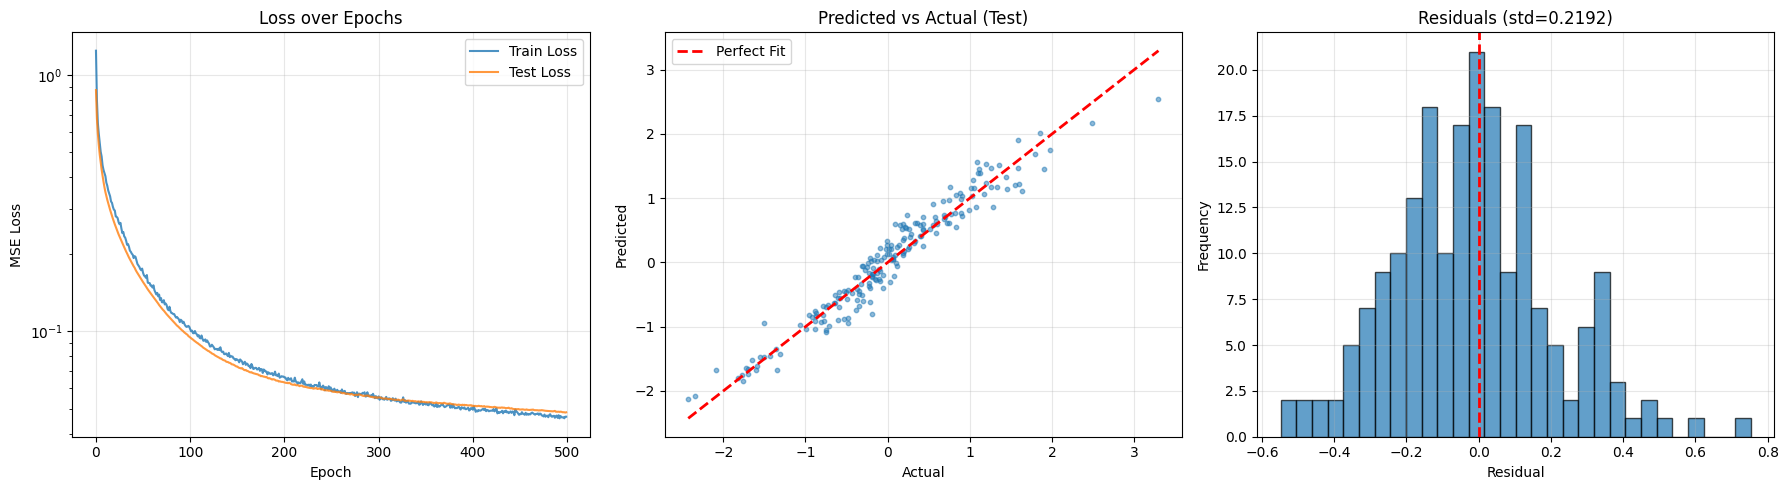


R-squared (Test): 0.941100
MAE: 0.170657


In [7]:
# ============================================================
# Section 7: Training Results Visualization
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', alpha=0.8)
axes[0].plot(test_losses, label='Test Loss', alpha=0.8)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Loss over Epochs')
axes[0].legend(); axes[0].set_yscale('log'); axes[0].grid(True, alpha=0.3)

# Predictions vs Actual
with torch.no_grad():
    y_final = forward(X_test, W1, b1, W2, b2, W3, b3, W4, b4).cpu().numpy()
y_true_np = y_test.cpu().numpy()

axes[1].scatter(y_true_np, y_final, alpha=0.5, s=10)
mn, mx = min(y_true_np.min(), y_final.min()), max(y_true_np.max(), y_final.max())
axes[1].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect Fit')
axes[1].set_xlabel('Actual'); axes[1].set_ylabel('Predicted')
axes[1].set_title('Predicted vs Actual (Test)'); axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Residuals
residuals = (y_true_np - y_final).flatten()
axes[2].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Residual'); axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Residuals (std={residuals.std():.4f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# R-squared
ss_res = np.sum((y_true_np - y_final) ** 2)
ss_tot = np.sum((y_true_np - y_true_np.mean()) ** 2)
r2 = 1 - ss_res / ss_tot
print(f"\nR-squared (Test): {r2:.6f}")
print(f"MAE: {np.mean(np.abs(residuals)):.6f}")

In [8]:
# ============================================================
# Section 8: Sample Predictions
# ============================================================
# Denormalize
y_test_actual = y_true_np * y_std + y_mean
y_pred_actual = y_final * y_std + y_mean
X_test_actual = X_test.cpu().numpy() * X_std + X_mean

print("Sample Predictions (Original Scale):")
print("=" * 70)
print(f"{'Idx':>5} | {'x1':>7} | {'x2':>7} | {'x3':>7} | {'Actual':>9} | {'Predicted':>9} | {'Error':>7}")
print("-" * 70)
for i in range(15):
    a = y_test_actual[i, 0]
    p = y_pred_actual[i, 0]
    print(f"{i:5d} | {X_test_actual[i,0]:7.3f} | {X_test_actual[i,1]:7.3f} | {X_test_actual[i,2]:7.3f} | {a:9.4f} | {p:9.4f} | {abs(a-p):7.4f}")

print(f"\nOverall RMSE: {np.sqrt(np.mean((y_test_actual-y_pred_actual)**2)):.4f}")
print(f"R-squared: {r2:.6f}")
print("\n=== Colab B Complete ===")
print("Key point: Entire network built from raw PyTorch tensors")
print("NO nn.Module, NO nn.Linear, NO nn.functional, NO optimizer!")

Sample Predictions (Original Scale):
  Idx |      x1 |      x2 |      x3 |    Actual | Predicted |   Error
----------------------------------------------------------------------
    0 |   0.829 |   1.826 |   1.170 |    5.2825 |    5.7224 |  0.4398
    1 |  -1.390 |   0.950 |   1.632 |    1.7257 |    1.7343 |  0.0086
    2 |   0.305 |  -0.587 |   1.775 |   -1.8073 |   -1.4353 |  0.3720
    3 |   0.427 |  -0.814 |   1.841 |   -2.5965 |   -2.4028 |  0.1937
    4 |  -0.303 |  -0.601 |   0.086 |   -0.4148 |   -0.7065 |  0.2917
    5 |   0.946 |   1.099 |   1.909 |    4.6694 |    3.1831 |  1.4863
    6 |   1.737 |   0.645 |   1.029 |    1.9903 |    2.0436 |  0.0533
    7 |   1.702 |  -1.259 |  -1.353 |   -0.3670 |    0.0866 |  0.4535
    8 |  -0.197 |  -1.304 |  -0.092 |   -0.5389 |   -0.4866 |  0.0524
    9 |  -1.547 |  -1.606 |   0.873 |   -4.7987 |   -4.9134 |  0.1147
   10 |   1.939 |   0.641 |  -1.011 |    2.0689 |    1.7506 |  0.3183
   11 |   1.356 |   1.057 |   0.562 |    2.5738 |   